# Bildverarbeitung mit Python
Gert-Ludwig Ingold
<div style="margin-top:10ex;font-size:smaller">Quellen: `git clone https://github.com/gertingold/lit2017`</div>

## Bearbeitung digitaler Bilder unter Linux

 * `darktable`
 * `gimp`
 * ...
 * **hier:** `Python`  
   * skriptbasiert, hohe Reproduzierbarkeit
   * Möglichkeit zur Inspektion des Codes in frei verfügbaren Programmbibliotheken
   * Möglichkeit zum freien Experimentieren
   * Bearbeitung von größeren Bildmengen
   * Auswertung wissenschaftlicher Bilder

## Digitale Bilder sind numerische Daten
![foo](img/imagearrays.png)

→ verwende ndarray von NumPy

## Pythons wissenschaftliches Ökosystem

 1. **NumPy**  
    stellt Arrays und die zugehörige Funktionalität zur Verfügung  
    bildet die Basis für alle weiteren Pakete
 2. **SciPy**  
    umfangreiche wissenschaftliche Programmbibliothek  
    bietet auch grundlegende Unterstützung für Bildverarbeitung
 3. **Matplotlib**  
    wird hier zur Darstellung der Bilder benutzt
 4. **Scikit Image**  
    Scikits sind spezialisierte Erweiterungen zu SciPy  
    Scikit Image konzentriert sich auf die Bildverarbeitung
 5. **+ ...**

### SciPy Lecture Notes
#### `www.scipy-lectures.org`
![foo](img/ScipyLectCover.png)

* Verwendete Pakete
  * `NumPy` und `SciPy`  
    http://scipy.org
  * `matplotlib`  
    http://matplotlib.org
  * `scikit-image`  
    http://scikit-image.org

* Die Quellen aller Pakete sind auf Github verfügbar.

* Python-Distribution mit allem was man hier braucht:
  * `Anaconda`  
    http://continuum.io

### Die Zutaten

In [1]:
%matplotlib inline
import numpy as np
from scipy import misc, ndimage
import matplotlib.pyplot as plt
from skimage import color, data, draw, exposure, filters, measure

### Unser Wegbegleiter

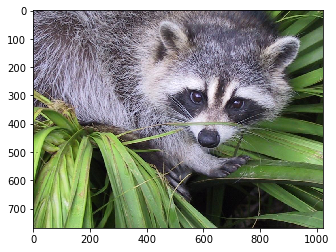

In [2]:
plt.imshow(misc.face())

## Speichern und Lesen eines Bildes

In [3]:
misc.imsave('face.png', misc.face())

### Bilddaten im PNG-Format

In [4]:
with open('face.png', 'rb') as file:
    print(file.read(20))

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\x00'


### Bilddaten als NumPy-Array

In [5]:
waschbär = misc.imread('face.png')

In [6]:
type(waschbär)

numpy.ndarray

In [7]:
waschbär.shape

(768, 1024, 3)

In [8]:
waschbär

array([[[121, 112, 131],
        [138, 129, 148],
        [153, 144, 165],
        ..., 
        [119, 126,  74],
        [131, 136,  82],
        [139, 144,  90]],

       [[ 89,  82, 100],
        [110, 103, 121],
        [130, 122, 143],
        ..., 
        [118, 125,  71],
        [134, 141,  87],
        [146, 153,  99]],

       [[ 73,  66,  84],
        [ 94,  87, 105],
        [115, 108, 126],
        ..., 
        [117, 126,  71],
        [133, 142,  87],
        [144, 153,  98]],

       ..., 
       [[ 87, 106,  76],
        [ 94, 110,  81],
        [107, 124,  92],
        ..., 
        [120, 158,  97],
        [119, 157,  96],
        [119, 158,  95]],

       [[ 85, 101,  72],
        [ 95, 111,  82],
        [112, 127,  96],
        ..., 
        [121, 157,  96],
        [120, 156,  94],
        [120, 156,  94]],

       [[ 85, 101,  74],
        [ 97, 113,  84],
        [111, 126,  97],
        ..., 
        [120, 156,  95],
        [119, 155,  93],
        [118, 154,

## Schwarz-Weiß-Bilder

In [9]:
waschbär_sw = misc.face(gray=True)

In [10]:
waschbär_sw

array([[114, 130, 145, ..., 119, 129, 137],
       [ 83, 104, 123, ..., 118, 134, 146],
       [ 68,  88, 109, ..., 119, 134, 145],
       ..., 
       [ 98, 103, 116, ..., 144, 143, 143],
       [ 94, 104, 120, ..., 143, 142, 142],
       [ 94, 106, 119, ..., 142, 141, 140]], dtype=uint8)

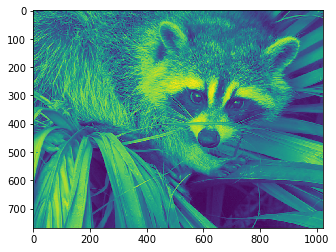

In [11]:
plt.imshow(waschbär_sw)

Standardfarbskala von Matplotlib: `cm.viridis`

für Schwarz-Weiß-Bilder besser: `cm.gray`

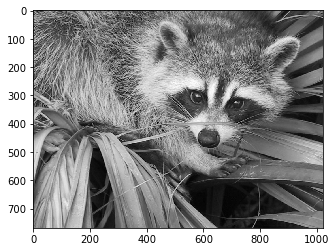

In [12]:
plt.imshow(waschbär_sw, cmap=plt.cm.gray)

## Bearbeitung mit Standard-NumPy-Methoden

### Rahmung eines Bildes

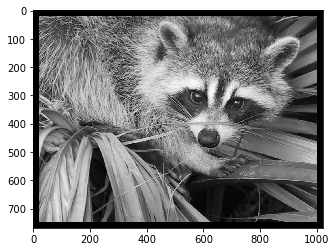

In [13]:
gerahmtes_bild = np.zeros_like(waschbär_sw)
rand = 20
gerahmtes_bild[rand:-rand, rand:-rand] = waschbär_sw[rand:-rand, rand:-rand]
plt.imshow(gerahmtes_bild, cmap=plt.cm.gray)

* mit Nullen gefülltes Array bedeutet schwarze Fläche
* Einblenden eines Teilbildes unter Verwendung der Slicing-Syntax  
  (vergleiche Slicing bei Python-Listen)

### Veränderung des Farbtons

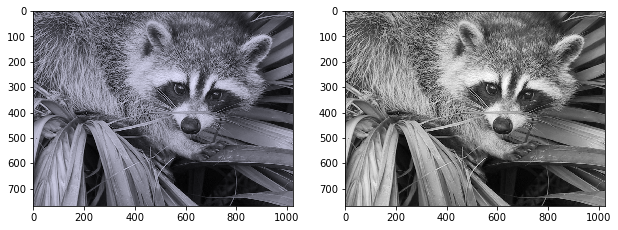

In [14]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10.24, 7.68))
ax0.imshow(np.array(waschbär_sw[:, :, np.newaxis]*np.array([0.9, 0.9, 1.0]),
                    dtype=np.uint8))
ax1.imshow(waschbär_sw, cmap=plt.cm.gray)

* Schwarz-Weiß-Bild wird in Farbbild umgewandelt  
  → eine dritte Achse muss hinzugefügt werden (`np.newaxis`)
* NumPy Broadcasting: der RGB-Wert wird in die dritte Achse eingefügt  
  → Verstärkung des Blaukanals im Vergleich zum rechten Originalbild

### Maskierung eines Bildes

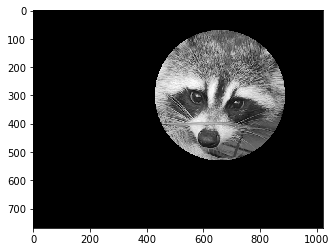

In [15]:
maskierter_waschbär = waschbär_sw[:, :]
centerx, centery = 660, 300
radius = 230
sy, sx = waschbär_sw.shape
y, x = np.ogrid[:sy, :sx]
maske = ((y-centery)**2 + (x-centerx)**2) > radius**2
maskierter_waschbär[maske] = 0
plt.imshow(maskierter_waschbär, cmap=plt.cm.gray)

* Maske enthält Wahrheitswerte  
  `True`: Punkt liegt außerhalb des gewählten Kreises  
  `False`: Punkt liegt innerhalb des gewählten Kreises
* Adressierung mit booleschem Array (`maske`)

## Transformationen

* aus `scipy.ndimage`
* interpoliert bei Bedarf

### Verschiebung

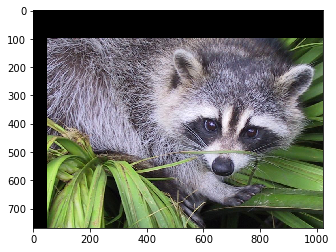

In [17]:
plt.imshow(ndimage.shift(waschbär, (100, 50, 0)))

### Zoom

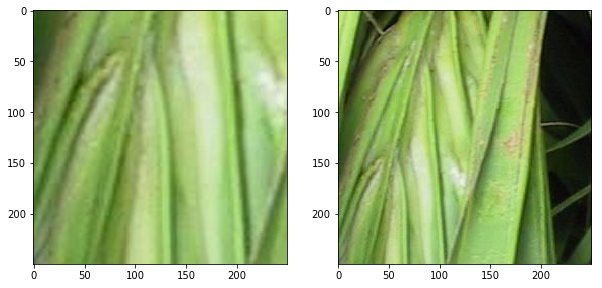

In [19]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 10))
ax0.imshow(ndimage.zoom(waschbär, (2, 2, 1))[-250:, :250])
ax1.imshow(waschbär[-250:, :250])

### Drehung

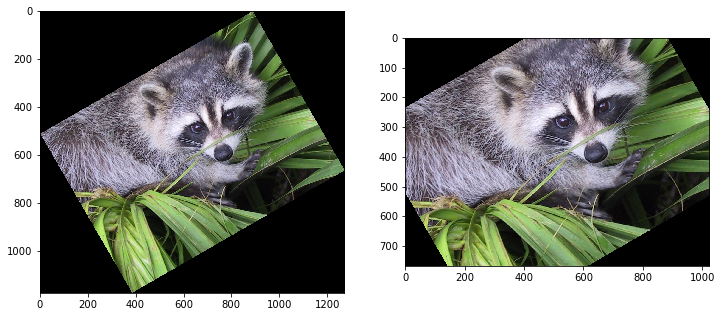

In [21]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 8))
ax0.imshow(ndimage.rotate(waschbär, 30))
ax1.imshow(ndimage.rotate(waschbär, 30, reshape=False))

### Stürzende Linien

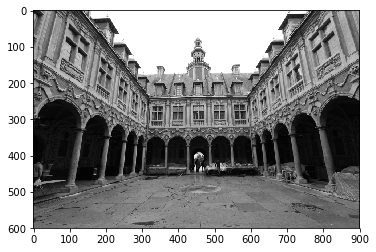

In [22]:
lille = misc.imread('img/lille.png')
plt.imshow(lille, cmap=plt.cm.gray)

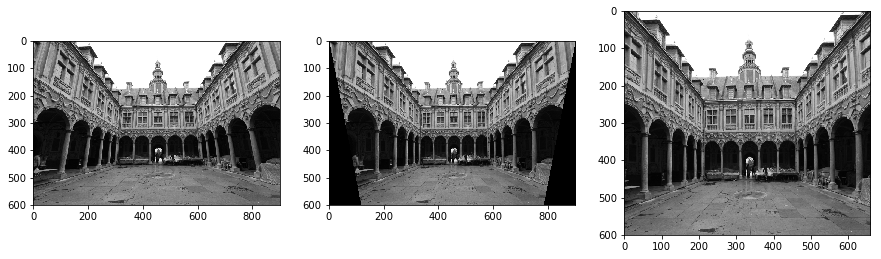

In [23]:
def mapfunc(output_coords, *args):
    xp, yp = output_coords
    xmax, ymax = args[0]
    fak = args[1]
    yorig = (yp-(1-fak)*xp/xmax*0.5*ymax)/(fak+(1-fak)*(1-xp/xmax))
    return (xp, yorig)

lille_trafo = ndimage.geometric_transform(lille, mapping=mapfunc,
                                          extra_arguments=(lille.shape, 0.74))

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 8))
ax0.imshow(lille, cmap=plt.cm.gray)
ax1.imshow(lille_trafo, cmap=plt.cm.gray)
ax2.imshow(lille_trafo[:, 120:780], cmap=plt.cm.gray)

### Der exponentierte Waschbär

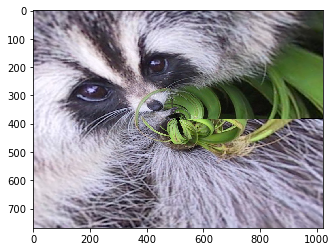

In [24]:
def mapfunc(output_coords, *args):
    xp, yp, zp = output_coords
    xmax, ymax, _ = args[0]
    xp = 3-6*xp/xmax
    yp = 3-6*yp/ymax
    xorig = 0.5*xmax*(1-np.log(xp**2+yp**2+1e-12)/(2*np.pi))
    yorig = 0.5*ymax*(1+np.arctan2(xp, yp)/np.pi)
    return (xorig, yorig, zp)

plt.imshow(ndimage.geometric_transform(waschbär, mapping=mapfunc,
                                       extra_arguments=(waschbär.shape,)))

## Histogramm

In [ ]:
plt.plot(ndimage.histogram(waschbär, min=0, max=255, bins=256))

In [ ]:
for column, farbe in enumerate(('r', 'g', 'b')):
    plt.plot(ndimage.histogram(face[:, :, column], min=0, max=255, bins=256), farbe)

In [ ]:
cdf = exposure.cumulative_distribution(waschbär)
plt.plot(cdf[1], cdf[0])

In [ ]:
waschbär_eq = exposure.equalize_hist(waschbär)

In [ ]:
plt.plot(ndimage.histogram(255*waschbär_eq, min=0, max=255, bins=256))

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10.24, 7.68))
ax0.imshow(waschbär_eq, cmap=plt.cm.gray)
ax1.imshow(waschbär, cmap=plt.cm.gray)

In [ ]:
cdf = exposure.cumulative_distribution(waschbär_eq)
plt.plot(cdf[1], cdf[0])

In [ ]:
label = np.zeros(shape=face.shape[:2])
label[np.logical_and(face[:, :, 1] > face[:, :, 0], face[:, :, 1] > face[:, :, 2])] = 1
label[np.logical_and(face[:, :, 2] > face[:, :, 0], face[:, :, 2] > face[:, :, 1])] = 2
colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]
rgb = color.colorlabel.label2rgb(label, image=face, colors=colors, alpha=0.35, image_alpha=1)
plt.imshow(rgb)

In [ ]:
face = misc.face()
masked_face = np.ones_like(face)*np.array([100, 80, 0], dtype=np.uint8)
e_rr, e_cc = draw.ellipse(250, 640, 250, 380, shape=face.shape)
masked_face[e_rr, e_cc, :] = face[e_rr, e_cc, :]

In [ ]:
plt.imshow(masked_face)

In [ ]:
for column, farbe in enumerate(('r', 'g', 'b')):
    plt.plot(measure.profile_line(face[:, :, column], (500, 0), (500, 1024)), farbe)

In [ ]:
plt.imshow(filters.sobel(data.text()), cmap=plt.cm.gray)

In [ ]:
plt.imshow(filters.sobel(data.coins()), cmap=plt.cm.gray)

## Messung von Farbabständen

In [ ]:
grün = color.colorconv.rgb2lab(np.array([0, 255, 0], dtype=np.uint8).reshape(1, 1, 3))

In [ ]:
face_lab = color.colorconv.rgb2lab(face)

In [ ]:
diff = color.delta_e.deltaE_cie76(face_lab, grün)
plt.plot(ndimage.histogram(diff, min=np.min(diff), max=np.max(diff), bins=100))

In [ ]:
schwelle = 115
face_ohne_grün = np.zeros_like(face)
face_ohne_grün[diff > schwelle] = face[diff > schwelle]
fig1, (ax0, ax1) = plt.subplots(1, 2, figsize=(10.24, 7.68))
ax0.imshow(face_ohne_grün)
ax1.imshow(face)